## Примеры

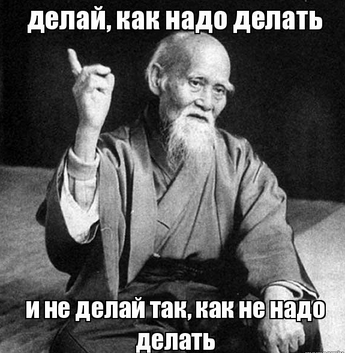

В этом файле предлагаю собирать примеры подводных камней в используемых библиотеках

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.encoding import WoEEncoder
from sklearn import impute

In [2]:
def create_test_df(nans = True):
    x1 = np.random.normal(size = 10000)
    x2 = np.random.normal(size = 10000)*x1
    x3 = np.random.normal(size = 10000) + x2
    if nans == True:
        x4 = np.random.choice(a = [np.random.normal(), None], size = 10000)
        xcat = np.random.choice(a = ["a", "b", "c", "d", None], size = 10000)
    else:
        x4 = np.random.choice(a = [np.random.normal()], size = 10000)
        xcat = np.random.choice(a = ["a", "b", "c", "d", "e"], size = 10000)
    target = np.random.choice(a = [0,1], size = 10000)

    test_df = pd.DataFrame({"x1" : x1,
                           "x2" : x2,
                           "x3" : x3,
                           "x4" : x4,
                            "xcat" : xcat,
                            "target" : target
                           } )
    return test_df

### 1. Переменные в pipeline

Pipeline из sklearn требует, чтобы переменные Х и y (для датасета и таргета) принимались методом fit, а не самим классом. Для примера разберем два класса: 

Создадим простой класс, чтобы заменить пропущенные значения в категориальных переменных заранее выбранным значением. Подадим X и Y инстансу класса через init:

In [35]:
class missing_filler_category():
    
    """
    Returns a table with all the missing values filled with special category.
    params::x DataFrame with the data
    params::filling_category a value to fill the missing values
    """
    
    def __init__(self, x, y = None, filling_category = "filler"):
        self.x = x.copy()
        self.filling_category = filling_category
        
    def fit(self):
        return self
    
    def transform(self):
        self.x.fillna(self.filling_category, inplace = True)
        filled_table = self.x
        return filled_table
    

In [68]:
#работает
test_df = create_test_df()
obj = missing_filler_category(test_df)
obj.fit()
obj.transform()

,x1,x2,x3,x4,xcat,target
0,0.216945,0.457200,0.347635,filler,d,0
1,0.097965,-0.043713,0.847542,-0.428399,b,0
2,1.524203,-1.572497,-1.919804,-0.428399,d,0
3,0.701261,1.065420,1.071502,filler,c,0
4,0.759806,0.582500,1.548470,filler,a,0
...,...,...,...,...,...,...
9995,1.085727,-0.329557,1.321218,filler,filler,1
9996,-0.764181,-0.816888,-0.385269,filler,c,0
9997,1.073704,-0.978325,0.061199,-0.428399,b,0
9998,0.009949,0.007496,0.791923,-0.428399,filler,0


Попробуем использовать модуль в пайплайне, получаем ошибку

In [97]:
y_train = test_df.target
test_df = test_df.drop("target",1)

missing_impute = missing_filler_category(test_df)

mdl_pipe_impute = Pipeline(
    [('impute_missing', missing_impute)]
)

mdl_pipe_impute.fit(test_df, y_train)

TypeError: fit() takes 1 positional argument but 3 were given

Перепишем модуль так, как я описал в начале:

In [72]:
class missing_filler_category_new():
    
    """
    Returns a table with all the missing values filled with special category.
    params::x DataFrame with the data
    params::filling_category a value to fill the missing values
    """
    
    def __init__(self,  filling_category = "filler"):
        self.filling_category = filling_category
        
    def fit(self, x, y = None):
        self.x = x.copy()
        return self
    
    def transform(self, x, y = None):
        self.x = x.copy()
        self.x.fillna(self.filling_category, inplace = True)
        filled_table = self.x
        return filled_table
    

In [84]:
#работает так же
test_df = create_test_df()
obj = missing_filler_category(test_df)
obj.fit()
obj.transform()

,x1,x2,x3,x4,xcat,target
0,1.425592,-0.176278,-0.795582,0.906293,c,1
1,-1.739805,-2.841100,-2.947457,0.906293,d,0
2,-0.307079,0.439274,-0.822769,filler,b,1
3,0.190226,0.323325,0.006596,0.906293,filler,0
4,-0.616574,0.962279,2.474005,0.906293,c,1
...,...,...,...,...,...,...
9995,2.181601,2.262704,1.650524,filler,d,0
9996,1.267897,0.722239,0.117882,0.906293,a,1
9997,-1.121639,0.801573,0.883677,0.906293,d,0
9998,0.108454,0.078128,-0.145147,filler,filler,1


Зато работает в пайплайне:

In [85]:
y_train = test_df.target
test_df = test_df.drop("target",1)

missing_impute = missing_filler_category_new(test_df)

mdl_pipe_impute = Pipeline(
    [('impute_missing', missing_impute)]
)

mdl_pipe_impute.fit(test_df, y_train)

Pipeline(steps=[('impute_missing',
                 <__main__.missing_filler_category_new object at 0x0000025244153AF0>)])

### 2. Редкие категории в WOE

Если попытаться применить функцию WoEEncoder из feature_engine.encoding к данным, где есть хотя бы одна категория категориальной переменной, для которой не представлено значений одного из классов зависимой переменной, то она выдаст ошибку. 

In [101]:
#сделаем так, чтобы для категории "a" не было наблюдений типа 1
test_df = create_test_df(nans = False)
test_df.loc[test_df.xcat == "a", "target"] = 0
y_train = test_df.target
test_df = test_df.drop("target",1)


In [103]:
#Бум
woe = WoEEncoder(variables = ["xcat"])
woe.fit(test_df, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: The proportion of one of the classes for a category in variable xcat is zero, and log of zero is not defined

### 3. sklearn.impute не умеет игнорить качественные переменные

Если в датасете есть качественная переменная, то функции из пакета sklearn.impute, рассчитанные на количественные переменные, выдают ошибку (а не игнорируют ее, как, например, feature_engine). Планирую написать дочерний класс, который это научится делать.

In [3]:
obj = impute.KNNImputer()
test_df = create_test_df()
obj.fit(test_df)
obj.transform(test_df)

ValueError: could not convert string to float: 'd'